In [1]:
import numpy as np
import tensorflow as tf
import jieba
import keras
from keras import utils
from keras.preprocessing import sequence
from keras.backend.tensorflow_backend import set_session
from keras.layers import Embedding,Dense,GlobalAveragePooling1D,Input,Activation
from keras.models import Model,Sequential
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# GPU使用配置
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.8  # 比例
config.gpu_options.allow_growth = True    # 按需
set_session(tf.Session(config=config))

np.random.seed(123)

In [3]:
def filter_word_frec_dic(word_frec_dic, min_num):
    word_frec_dic_new = {}
    for word, num in word_frec_dic.items():
        if num >= min_num:
            word_frec_dic_new[word] = num
    return word_frec_dic_new
    
# 获得词频字典
def get_word_frec_dic(filename):
    label_set = set()
    # 统计文档词频
    word_freq_dic = {}
    special_symbol = ['', '\t', ',', ':', ';', '。']
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            label, sentence = line.strip().split('\t')
            if len(label) != 0:
                label_set.add(label) 
            word_list = jieba.cut(sentence)   # 生成器
            for word in word_list:
                word = word.strip()
                if word in special_symbol:  # 过滤特殊符号
                    continue
                if word not in word_freq_dic:
                    word_freq_dic[word] = 1
                else:
                    word_freq_dic[word] += 1
    return word_freq_dic, label_set

# 不需要考虑顺序，为Word、label建立索引
def get_word_label_2index(word_frec_dic, label_set):
    """
    input:
        word_frac_dic: {"word1":123, "word2":345, ...}
        label_set: {"体育", "娱乐", ...}
    
    output:
        word2index: {"word1":0, "word2":1, ...}
        label2index: {"体育":0, "娱乐":1, ...}
    """
    word2index = {}
    lenth = len(word_frec_dic)
    for i, word in zip(range(lenth), word_frec_dic):
        word2index[word] = i

    label2index = {}
    for i, label in zip(range(len(label_set)), label_set):
        label2index[label] = i
    return word2index, label2index


def create_train_data(filename, word2index, label2index, padding_len=300):
    with open(filename, 'r', encoding='utf-8') as f:
        training_data = []
        for line in f:
            label, sentence = line.strip().split('\t')
            words = jieba.cut(sentence)
            sentence_word_index = [word2index[word] for word in words if word in word2index]
            label = [label2index[label]]
            training_data.append((sentence_word_index, label)) # 将特征和标签放一起读取 然后随机打乱

    np.random.shuffle(training_data)

    X = []
    y = []
    for feas, label in training_data:
        X.append(feas)
        y.append(label)

    # 相当于将词汇统一为300，多出的删除，少的补上0
    X = sequence.pad_sequences(X, maxlen=padding_len, padding='post', truncating='post')
    y = utils.to_categorical(y, num_classes=10)   # onehot
    
    X = np.array(X)  # 注意这里不是onehot
    y = np.array(y)
    return X, y

def split_train_test(X, y, train_ratio=0.9):
    n_split = int(len(X)*0.9)
    X_train = X[:n_split]
    X_test = X[n_split:]
    y_train = y[:n_split]
    y_test = y[n_split:]
    return X_train, X_test, y_train, y_test

# model
def fasttext(vocab_size, embedding_dim, label_num):
    model = Sequential() 
    model.add(Embedding(vocab_size, embedding_dim, input_length=300))
    model.add(GlobalAveragePooling1D())
    # model.add(Dense(label_num*5))  # 如果加上这一层，效果不好
    model.add(Dense(label_num))
    model.add(Activation(activation='sigmoid'))
    model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
    model.summary()
    return model


def plot(history):
    plt.subplot(211)
    plt.title("accuracy")
    plt.plot(history.history["acc"], color="r", label="train")
    plt.plot(history.history["val_acc"], color="b", label="validation")
    plt.legend(loc="best")

    plt.subplot(212)
    plt.title("loss")
    plt.plot(history.history["loss"], color="r", label="train")
    plt.plot(history.history["val_loss"], color="b", label="validation")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

## 数据集准备

In [4]:
filename = './data/cnews_train.txt'
min_num = 10    # 最小词频
padding_len = 300

In [5]:
word_freq_dic, label_set = get_word_frec_dic(filename)
word_freq_filter_dic = filter_word_frec_dic(word_freq_dic, min_num)
word2index, label2index = get_word_label_2index(word_freq_filter_dic, label_set)
# 读取训练数据集 返回可以直接入模型的特征和标签
X, y = create_train_data(filename, word2index, label2index, padding_len=padding_len)
X_train, X_test, y_train, y_test = split_train_test(X, y, train_ratio=0.9)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 1.012 seconds.
Prefix dict has been built succesfully.


In [6]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(len(word2index))

(4500, 300)
(4500, 10)
(500, 300)
(500, 10)
18651


## 模型训练

In [7]:
vocab_size = len(word2index)    
label_num = len(label2index)
embedding_dim = 200
batch_size = 128
epochs = 40

In [8]:
model = fasttext(vocab_size, embedding_dim, label_num)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 200)          3730200   
_________________________________________________________________
global_average_pooling1d_1 ( (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2010      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total params: 3,732,210
Trainable params: 3,732,210
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 通过fit的callbacks参数将回调函数传入模型中，这个参数接收一个回调函数列表，你可以传入任意个回调函数
callback_lists = [
    keras.callbacks.EarlyStopping(monitor = 'acc',  # 监控模型的验证精度
                                  patience = 10,),   # 如果精度在多于10轮的时间（即两轮）内不再改善，就中断训练
    # ModelCheckpoint用于在每轮过后保存当前权重
    keras.callbacks.ModelCheckpoint(filepath = 'fasttext_news_cf.model', # 目标文件的保存路径
                                    # 这两个参数的意思是，如果val_loss没有改善，那么不需要覆盖模型文件，
                                    # 这就可以始终保存在训练过程中见到的最佳模型
                                    monitor = 'val_loss', save_best_only = True,)
]

In [10]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_split=0.3, callbacks=callback_lists)

Train on 3150 samples, validate on 1350 samples
Epoch 1/40
3150/3150 [==============================] - 1s 320us/step - loss: 2.2864 - acc: 0.4083 - val_loss: 2.2649 - val_acc: 0.5896
Epoch 2/40
3150/3150 [==============================] - 0s 90us/step - loss: 2.2388 - acc: 0.5952 - val_loss: 2.2120 - val_acc: 0.5867
Epoch 3/40
3150/3150 [==============================] - 0s 92us/step - loss: 2.1745 - acc: 0.6054 - val_loss: 2.1432 - val_acc: 0.5785
Epoch 4/40
3150/3150 [==============================] - 0s 95us/step - loss: 2.0993 - acc: 0.6073 - val_loss: 2.0702 - val_acc: 0.5844
Epoch 5/40
3150/3150 [==============================] - 0s 92us/step - loss: 2.0225 - acc: 0.6305 - val_loss: 1.9984 - val_acc: 0.6067
Epoch 6/40
3150/3150 [==============================] - 0s 95us/step - loss: 1.9430 - acc: 0.6625 - val_loss: 1.9209 - val_acc: 0.6430
Epoch 7/40
3150/3150 [==============================] - 0s 94us/step - loss: 1.8497 - acc: 0.6959 - val_loss: 1.8235 - val_acc: 0.6711
Epoch 

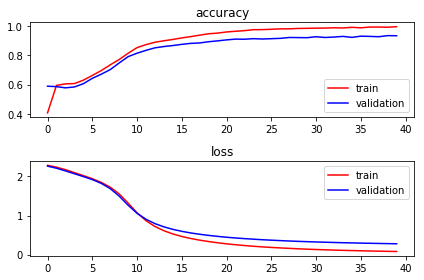

In [11]:
plot(history)

## 模型评测

In [12]:
from keras.models import load_model

In [13]:
model = load_model('fasttext_news_cf.model')
score = model.evaluate(X_test, y_test)   # 在测试模式下返回模型的误差值和评估标准值。
print(score)

500/500 [==============================] - 0s 164us/step
[0.30001683753728864, 0.932]


## 一些测试

In [14]:
sequence.pad_sequences([[1,2,3,3,3,2,8,8,8,8,8,8,77,8,8],[4,5,5]], maxlen=10, padding='post', truncating='post')

array([[1, 2, 3, 3, 3, 2, 8, 8, 8, 8],
       [4, 5, 5, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)

In [15]:
utils.to_categorical(range(10), num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

In [14]:
# Embedding 层
# padding_len
# input_length  这两个是否相等？
# https://blog.csdn.net/u010417185/article/details/79533539
# batch_size /epochs对神经网络的影响